In [1]:
import numpy as np
import torch

from imops import binary_opening, binary_dilation, binary_erosion
from imops import label
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.morphology import skeletonize, thin, ball

In [33]:
im = imread('../assets/sample_2.bmp')

In [34]:
im_gray = rgb2gray(im).astype(np.float32)

In [44]:
im_bin = im_gray > 0.5

In [45]:
im_opening = binary_opening(im_bin, ball(5)[:,:,5], num_threads=4)

In [46]:
def filter_ccs(bin_image, min_ratio=1e-3):
    ccs, labels, sizes = label(im_opening, return_labels=True, return_sizes=True)

    ratios = sizes / np.prod(bin_image.shape)

    return np.isin(ccs, labels[ratios >= min_ratio])

im_filtered = filter_ccs(im_opening)

In [47]:
def avg_filter(bin_image):
    bin_image = torch.from_numpy(bin_image).float()
    avg_image = torch.nn.functional.avg_pool2d(bin_image[None, None], kernel_size=5, stride=1, padding=2)[0, 0]
    bin_image = avg_image >= 0.7
    return bin_image

im_avg = avg_filter(im_filtered)

In [48]:
im_skeleton = skeletonize(im_filtered)
im_skeleton_ = binary_dilation(im_skeleton, ball(3)[:,:,3])

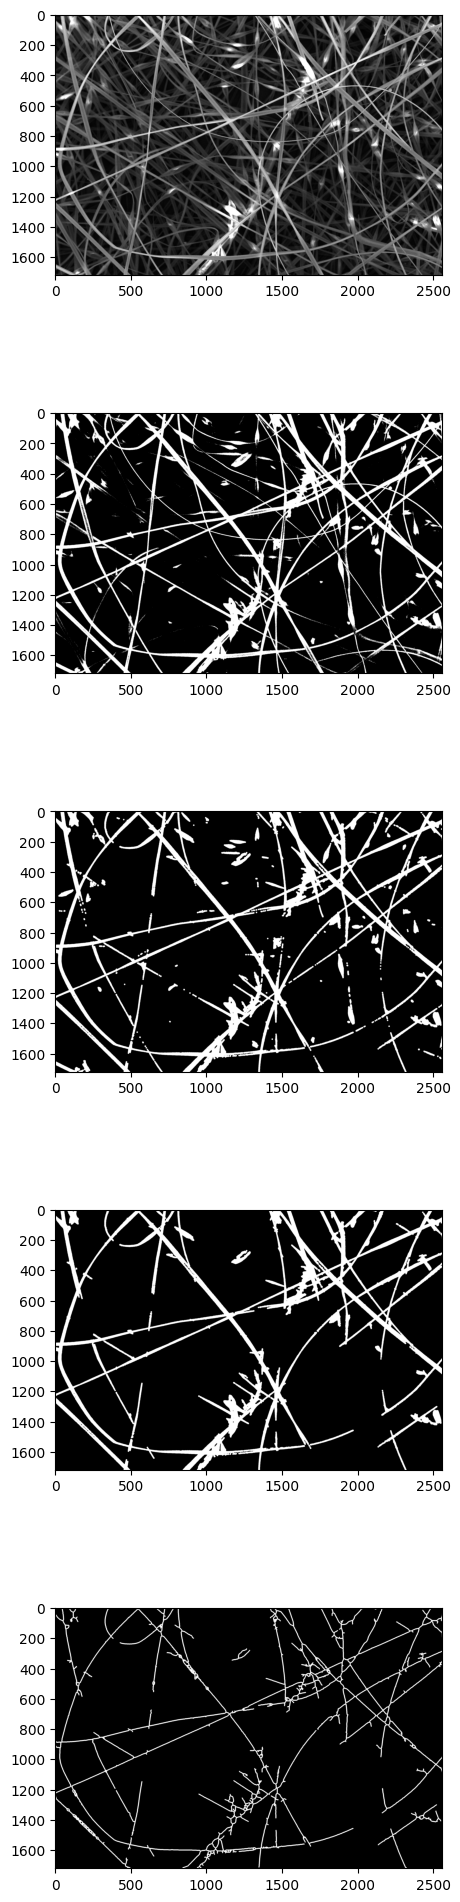

In [49]:
def visualize(*masks, width=5):
    masks = list(masks)
    N = len(masks)

    fig, axes = plt.subplots(N, figsize=(width, N * width))

    for ax, mask in zip(axes, masks):
        ax.imshow(mask, cmap='gray')

visualize(im_gray, im_bin, im_opening, im_filtered, im_skeleton_)

In [50]:
from scipy.stats import linregress
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_def


def blocked_lin_fit(skeleton, abs_rvalue_thr=0.8, block=16, filtration_image=None, filtration_thr=0.8):
    H, W = skeleton.shape

    result = np.zeros_like(skeleton)

    half_block = block // 2

    for i in tqdm_def(range((H + half_block - 1) // half_block)):
        for j in range((W + half_block - 1) // half_block):
            crop = skeleton[i * half_block: (i + 2) * half_block, j * half_block: (j + 2) * half_block]

            if crop.sum() >= 4:
                y, x = np.where(crop)

                if np.any(np.diff(x) != 0):
                    line_fit = linregress(x, y)
    
                    if np.abs(line_fit.rvalue) >= abs_rvalue_thr:
                        intercept, slope = line_fit.intercept, line_fit.slope
                        x_c, y_c = np.arange(block), np.arange(block)
    
                        block_lin_interp = np.abs(x_c[None, :] * slope + intercept - y_c[:, None]) < 2

                        assign_size = result[i * half_block: (i + 2) * half_block, j * half_block: (j + 2) * half_block].shape
                        block_lin_interp = block_lin_interp[:assign_size[0], :assign_size[1]]

                        if filtration_image is None:
                            result[i * half_block: (i + 2) * half_block, j * half_block: (j + 2) * half_block] = block_lin_interp
                        else:
                            filtration_crop = filtration_image[i * half_block: (i + 2) * half_block, j * half_block: (j + 2) * half_block]
                            
                            if block_lin_interp.sum() * filtration_thr <= (filtration_crop & block_lin_interp).sum():
                                result[i * half_block: (i + 2) * half_block, j * half_block: (j + 2) * half_block] = block_lin_interp

    return result

100%|█████████████████████████████████████████████████████| 54/54 [00:00<00:00, 85.87it/s]


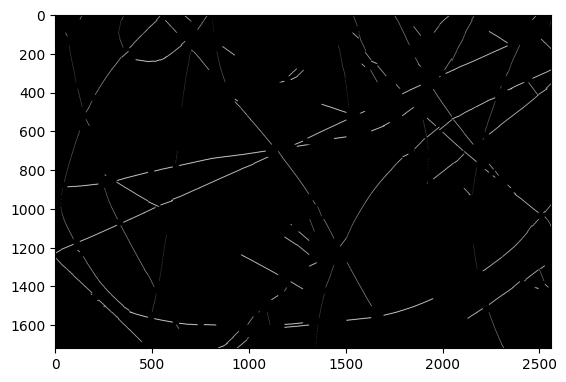

In [51]:
plt.imshow(blocked_lin_fit(im_skeleton, abs_rvalue_thr=0.9, block=64, filtration_image=im_filtered, filtration_thr=0.8), cmap='gray')
plt.show()

In [22]:
tosave = blocked_lin_fit(im_skeleton, abs_rvalue_thr=0.9, block=64, filtration_image=im_filtered)

100%|████████████████████████████████████████████████████| 55/55 [00:00<00:00, 214.87it/s]


In [109]:
imsave('../assets/sample_1_skeleton.bmp', tosave)

C:\Users\nikit\AppData\Local\Temp\ipykernel_26676\1139748796.py:1: UserWarning: ../assets/sample_1_skeleton.bmp is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave('../assets/sample_1_skeleton.bmp', tosave)
D:\python3.12\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../assets/sample_1_skeleton.bmp is a low contrast image
  return func(*args, **kwargs)
